In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [59]:
train_dir = './Training'
test_dir = './Testing'

## EDA

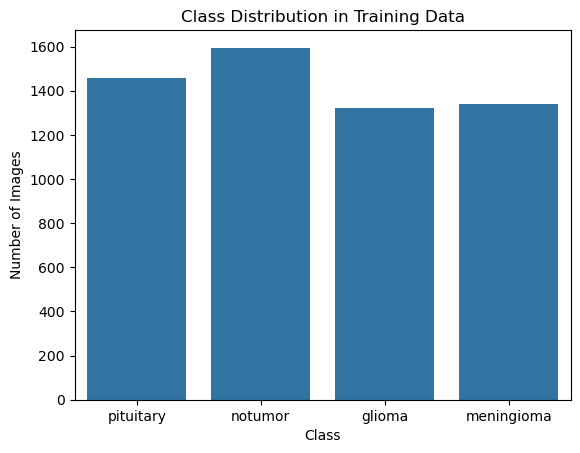

In [60]:
import os

# List the class names (folders in train_dir)
class_names = os.listdir(train_dir)

# Count the number of images in each class
class_counts = {}
for class_name in class_names:
    class_folder = os.path.join(train_dir, class_name)
    class_counts[class_name] = len(os.listdir(class_folder))

# Visualize the class distribution
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Class Distribution in Training Data')
plt.ylabel('Number of Images')
plt.xlabel('Class')
plt.show()

Unique image dimensions: [[ 150  198]
 [ 173  201]
 [ 177  197]
 [ 180  218]
 [ 192  192]
 [ 194  259]
 [ 196  257]
 [ 200  200]
 [ 200  210]
 [ 200  223]
 [ 200  235]
 [ 200  236]
 [ 200  243]
 [ 200  248]
 [ 200  252]
 [ 201  207]
 [ 201  210]
 [ 201  244]
 [ 201  249]
 [ 201  250]
 [ 201  251]
 [ 202  202]
 [ 202  223]
 [ 202  250]
 [ 203  243]
 [ 203  248]
 [ 204  247]
 [ 204  249]
 [ 205  214]
 [ 205  249]
 [ 205  251]
 [ 206  244]
 [ 206  245]
 [ 206  249]
 [ 207  207]
 [ 207  225]
 [ 207  243]
 [ 208  217]
 [ 208  225]
 [ 208  242]
 [ 208  243]
 [ 208  248]
 [ 208  278]
 [ 209  225]
 [ 209  234]
 [ 209  241]
 [ 209  242]
 [ 210  201]
 [ 210  213]
 [ 210  234]
 [ 210  240]
 [ 210  264]
 [ 211  236]
 [ 211  239]
 [ 212  222]
 [ 212  236]
 [ 212  237]
 [ 212  238]
 [ 212  280]
 [ 213  236]
 [ 213  237]
 [ 214  216]
 [ 214  235]
 [ 214  236]
 [ 215  220]
 [ 215  234]
 [ 216  202]
 [ 216  216]
 [ 216  234]
 [ 216  293]
 [ 216  302]
 [ 217  232]
 [ 217  248]
 [ 218  231]
 [ 218  234]


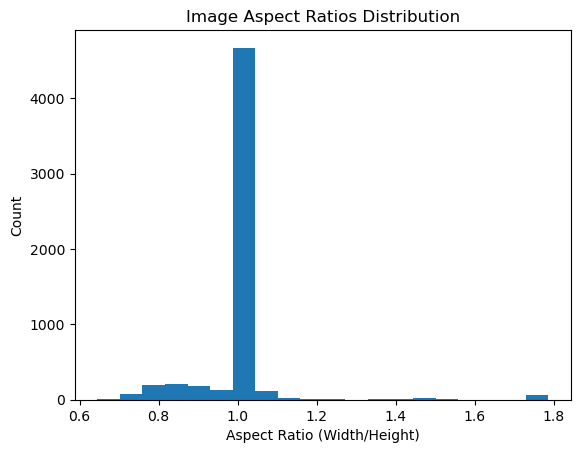

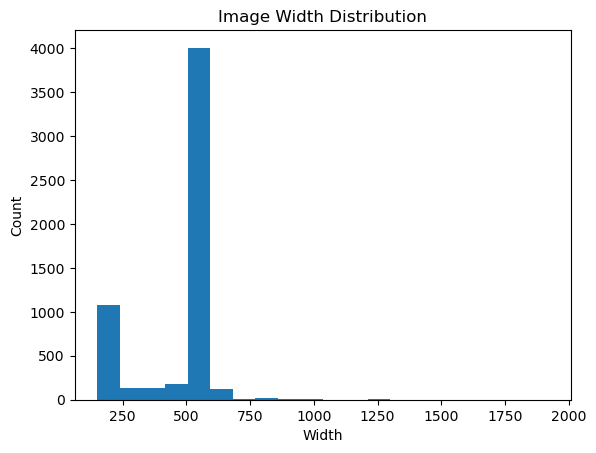

In [61]:
from PIL import Image

image_dims = []
for class_name in class_names:
    class_folder = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)
        img = Image.open(img_path)
        image_dims.append(img.size)

image_dims = np.array(image_dims)
print(f"Unique image dimensions: {np.unique(image_dims, axis=0)}")
print(value_counts := Counter([tuple(dim) for dim in image_dims]).most_common(10))

aspect_ratios = image_dims[:, 0] / image_dims[:, 1]
plt.hist(aspect_ratios, bins=20)
plt.title('Image Aspect Ratios Distribution')
plt.xlabel('Aspect Ratio (Width/Height)')
plt.ylabel('Count')
plt.show()

plt.hist(image_dims[:, 0], bins=20)
plt.title('Image Width Distribution')
plt.xlabel('Width')
plt.ylabel('Count')
plt.show()

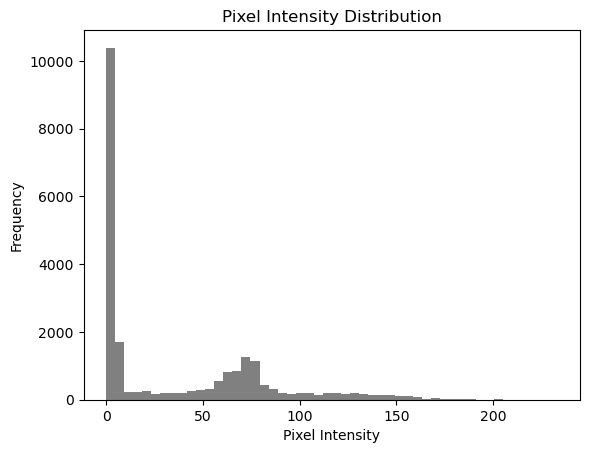

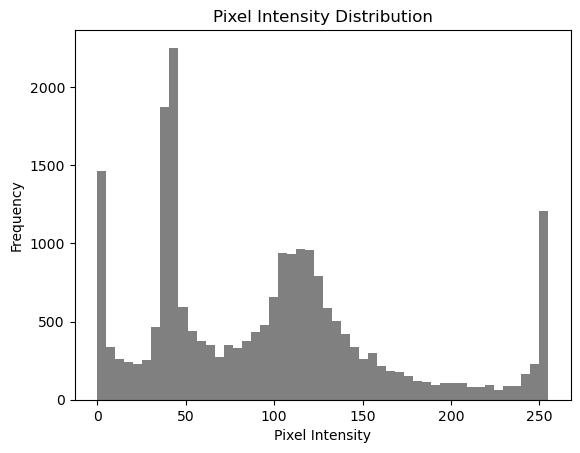

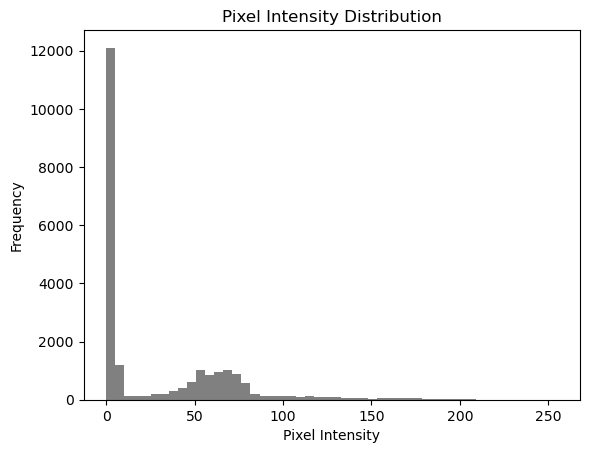

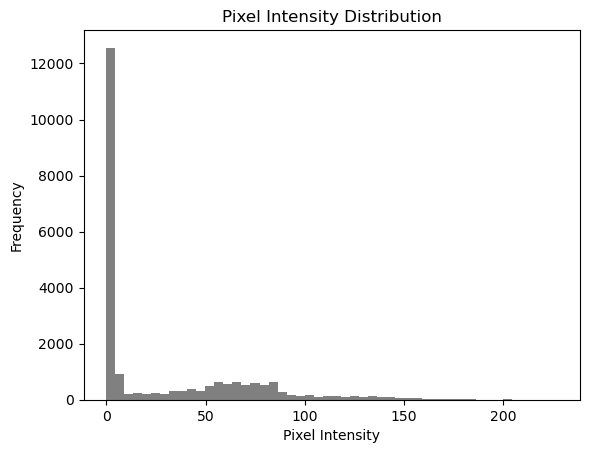

In [62]:
def plot_image_histogram(img_path):
    img = load_img(img_path, target_size=(150, 150), color_mode='grayscale')
    img_array = img_to_array(img).flatten()
    
    plt.hist(img_array, bins=50, color='gray')
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

# Plot the pixel intensity histogram for one sample image from each class
for class_name in class_names:
    class_folder = os.path.join(train_dir, class_name)
    img_path = os.path.join(class_folder, os.listdir(class_folder)[0])
    plot_image_histogram(img_path)

In [104]:
# Use ImageDataGenerator to import images from the class folders
# Apply data augmentation to the training dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=10,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #zoom_range=0.1,
    #horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical'
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [105]:
train_data.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [106]:
# Class counts seem fairly balanced
class_count = Counter(train_data.classes)
class_count

Counter({2: 1276, 3: 1166, 1: 1072, 0: 1057})

In [139]:
validation_data.samples

1141

In [138]:
test_data.samples

1311

In [137]:
train_data.samples

4571

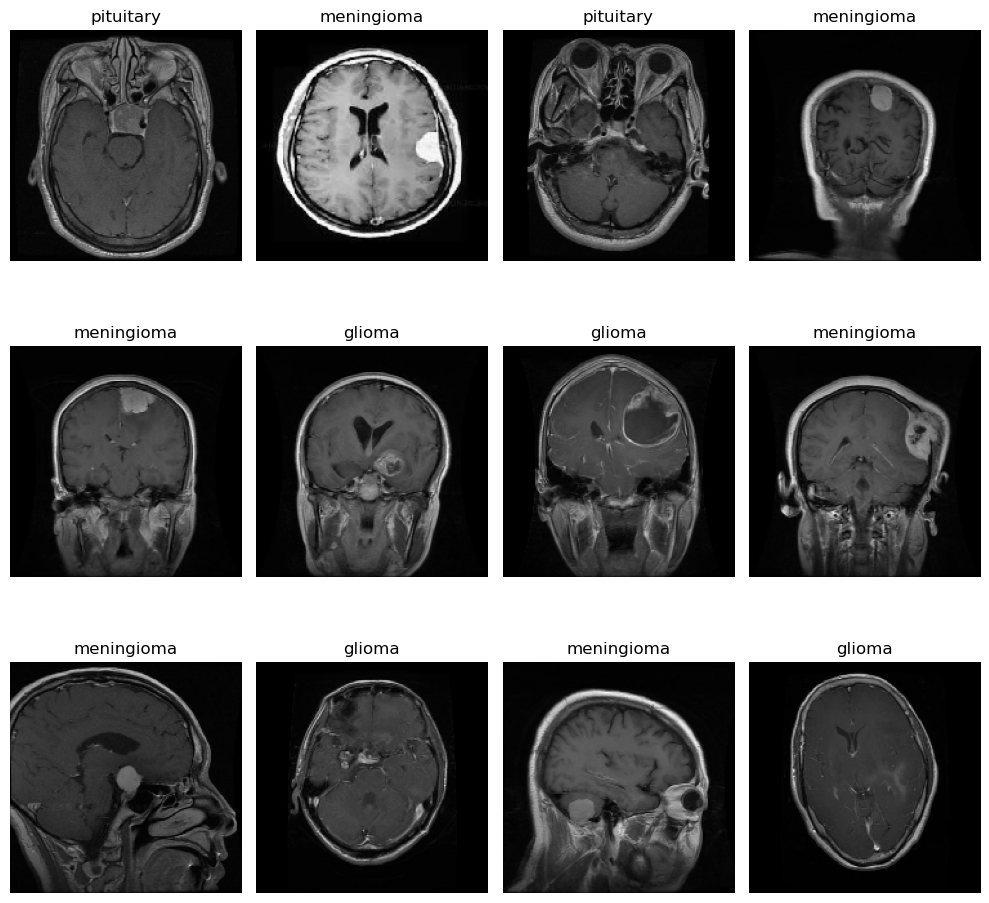

In [107]:
images, labels = next(train_data)
class_names = list(train_data.class_indices.keys())

def plot_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    
    # Display 9 images from the batch
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i])
        label_index = np.argmax(labels[i])
        plt.title(class_names[label_index])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_images(images, labels, class_names)

In [108]:
images[0].shape

(180, 180, 3)

## Model 1: ANN model

In [109]:
num_hidden1 = 256
num_hidden2 = 128
num_hidden3 = 64
num_hidden4 = 32
num_output = 4
model = Sequential([
    Flatten(input_shape=(180, 180, 3)),
    Dense(num_hidden1, activation = 'relu'),
    Dense(num_hidden2, activation = 'relu'),
    Dense(num_hidden3, activation = 'relu'),
    Dense(num_hidden4, activation = 'relu'),
    Dense(num_output, activation = 'softmax')
])

In [110]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [111]:
epochs = 10
history = model.fit(train_data, validation_data=validation_data, epochs=epochs)

Epoch 1/10


2024-10-02 20:32:29.266524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


143/143 [==============================] - ETA: 0s - loss: 1.3229 - accuracy: 0.6200

2024-10-02 20:32:35.874601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


143/143 [==============================] - 9s 58ms/step - loss: 1.3229 - accuracy: 0.6200 - val_loss: 1.7859 - val_accuracy: 0.6363
Epoch 2/10
143/143 [==============================] - 8s 55ms/step - loss: 0.5252 - accuracy: 0.7994 - val_loss: 1.4635 - val_accuracy: 0.6082
Epoch 3/10
143/143 [==============================] - 8s 54ms/step - loss: 0.4307 - accuracy: 0.8394 - val_loss: 1.4580 - val_accuracy: 0.6258
Epoch 4/10
143/143 [==============================] - 7s 52ms/step - loss: 0.4212 - accuracy: 0.8315 - val_loss: 1.6484 - val_accuracy: 0.5434
Epoch 5/10
143/143 [==============================] - 8s 56ms/step - loss: 0.2910 - accuracy: 0.8891 - val_loss: 1.3141 - val_accuracy: 0.6661
Epoch 6/10
143/143 [==============================] - 8s 55ms/step - loss: 0.2208 - accuracy: 0.9215 - val_loss: 1.9129 - val_accuracy: 0.5960
Epoch 7/10
143/143 [==============================] - 7s 52ms/step - loss: 0.2377 - accuracy: 0.9083 - val_loss: 1.3577 - val_accuracy: 0.6968
Epoch 8/10

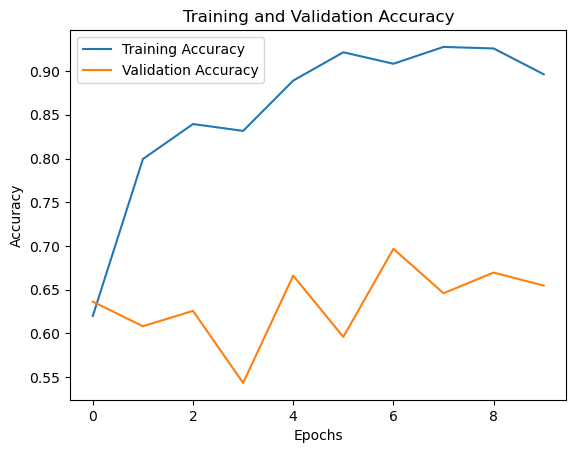

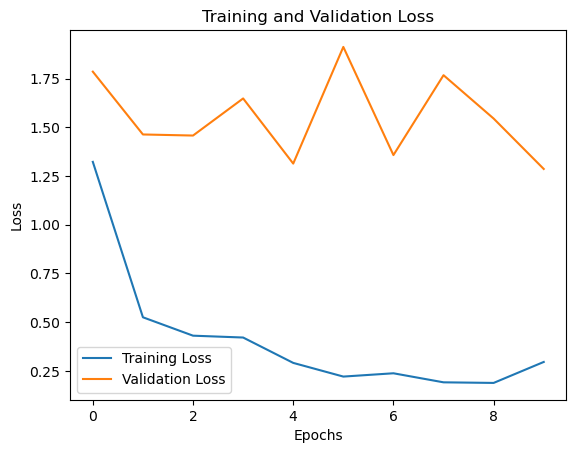

In [112]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [113]:
#use the model on test data and evaluate the performance
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

 3/41 [=>............................] - ETA: 1s - loss: 0.4646 - accuracy: 0.8125

2024-10-02 20:33:57.054750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


41/41 [==============================] - 2s 38ms/step - loss: 0.5214 - accuracy: 0.8398
Test loss: 0.521439790725708
Test accuracy: 0.8398169279098511


 5/41 [==>...........................] - ETA: 1s

2024-10-02 20:33:59.753314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


41/41 [==============================] - 1s 32ms/step


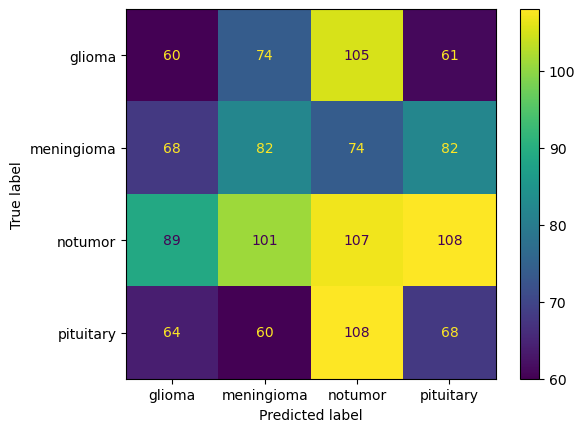

In [114]:
# display the confusion matrix
predictions = model.predict(test_data)
y_pred = np.argmax(predictions, axis=1)
y_true = test_data.classes
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()

Regular ANN model does not seem to have a great performance. This is expected because brain tumor development is spatial related.

## Model 2: CNN Model

In [117]:
# Model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 20, 20, 128)    

In [118]:
epochs = 10
CNNhistory = model.fit(
    train_data,
    epochs=epochs,
    validation_data=validation_data
)

Epoch 1/10


2024-10-02 20:34:23.630619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


143/143 [==============================] - ETA: 0s - loss: 0.6562 - accuracy: 0.7261

2024-10-02 20:35:01.736183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


143/143 [==============================] - 41s 286ms/step - loss: 0.6562 - accuracy: 0.7261 - val_loss: 0.7029 - val_accuracy: 0.7318
Epoch 2/10
143/143 [==============================] - 38s 269ms/step - loss: 0.3506 - accuracy: 0.8665 - val_loss: 0.6476 - val_accuracy: 0.7677
Epoch 3/10
143/143 [==============================] - 38s 268ms/step - loss: 0.2421 - accuracy: 0.9101 - val_loss: 0.5707 - val_accuracy: 0.7914
Epoch 4/10
143/143 [==============================] - 39s 275ms/step - loss: 0.1620 - accuracy: 0.9339 - val_loss: 0.5925 - val_accuracy: 0.7967
Epoch 5/10
143/143 [==============================] - 38s 268ms/step - loss: 0.1291 - accuracy: 0.9534 - val_loss: 0.7725 - val_accuracy: 0.7905
Epoch 6/10
143/143 [==============================] - 39s 270ms/step - loss: 0.0931 - accuracy: 0.9663 - val_loss: 0.6411 - val_accuracy: 0.8142
Epoch 7/10
143/143 [==============================] - 41s 285ms/step - loss: 0.0592 - accuracy: 0.9777 - val_loss: 0.7482 - val_accuracy: 0.8

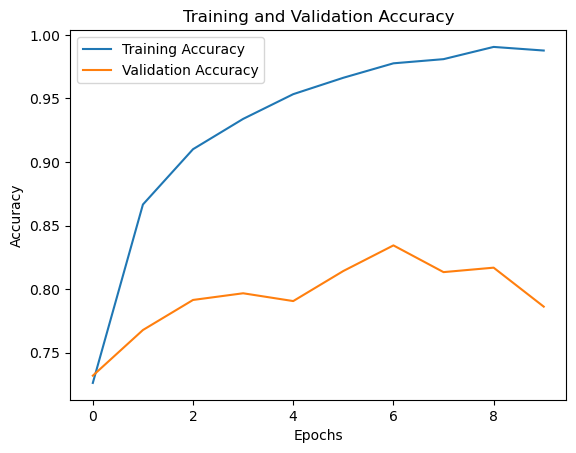

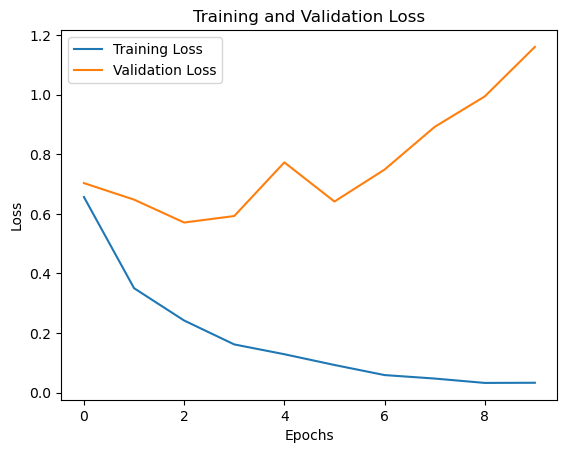

In [121]:
# Plot the training and validation accuracy
plt.plot(CNNhistory.history['accuracy'], label='Training Accuracy')
plt.plot(CNNhistory.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(CNNhistory.history['loss'], label='Training Loss')
plt.plot(CNNhistory.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [123]:
test_loss, test_acc = model.evaluate(test_data)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

 1/41 [..............................] - ETA: 5s - loss: 0.4839 - accuracy: 0.9375

2024-10-02 20:42:24.672942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


41/41 [==============================] - 3s 81ms/step - loss: 0.2484 - accuracy: 0.9405
Test accuracy: 0.9405034184455872
Test loss: 0.24836252629756927


 1/41 [..............................] - ETA: 6s

2024-10-02 20:43:02.499020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


41/41 [==============================] - 3s 80ms/step


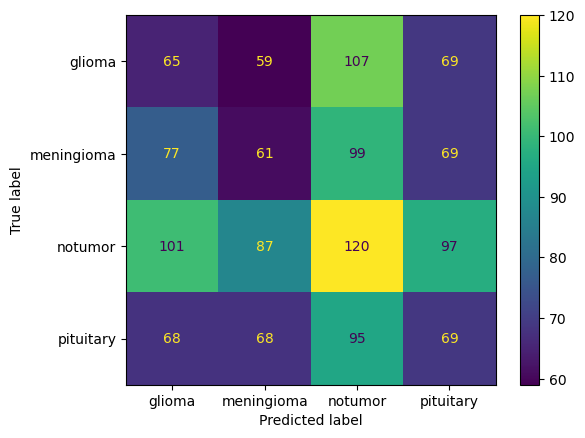

In [124]:
# display the confusion matrix
predictions = model.predict(test_data)
y_pred = np.argmax(predictions, axis=1)
y_true = test_data.classes
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()

## Model Finetuning

In [126]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint

def lr_schedule(epoch):
    initial_lr = 1e-3
    if epoch > 10:
        return initial_lr * 0.1
    return initial_lr

lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)
history = model.fit(
    train_data,
    epochs=40,
    validation_data=validation_data,
    callbacks=[lr_scheduler, early_stopping, model_checkpoint]
)

Epoch 1/40


2024-10-02 21:32:33.434935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


143/143 [==============================] - ETA: 0s - loss: 0.0481 - accuracy: 0.9825

2024-10-02 21:33:11.073331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


143/143 [==============================] - 41s 283ms/step - loss: 0.0481 - accuracy: 0.9825 - val_loss: 0.9219 - val_accuracy: 0.8195 - lr: 0.0010
Epoch 2/40
143/143 [==============================] - 38s 264ms/step - loss: 0.0207 - accuracy: 0.9921 - val_loss: 1.1043 - val_accuracy: 0.8124 - lr: 0.0010
Epoch 3/40
143/143 [==============================] - 38s 264ms/step - loss: 0.0319 - accuracy: 0.9897 - val_loss: 0.9581 - val_accuracy: 0.8589 - lr: 0.0010
Epoch 4/40
143/143 [==============================] - 39s 269ms/step - loss: 0.0284 - accuracy: 0.9906 - val_loss: 1.1284 - val_accuracy: 0.8186 - lr: 0.0010
Epoch 5/40
143/143 [==============================] - 40s 277ms/step - loss: 0.0165 - accuracy: 0.9954 - val_loss: 1.3487 - val_accuracy: 0.8081 - lr: 0.0010
Epoch 6/40
143/143 [==============================] - 42s 295ms/step - loss: 0.0251 - accuracy: 0.9928 - val_loss: 0.8458 - val_accuracy: 0.8720 - lr: 0.0010
Epoch 7/40
143/143 [==============================] - 43s 304ms

In [127]:
from tensorflow.keras.models import load_model
best_model = load_model('best_model.h5')

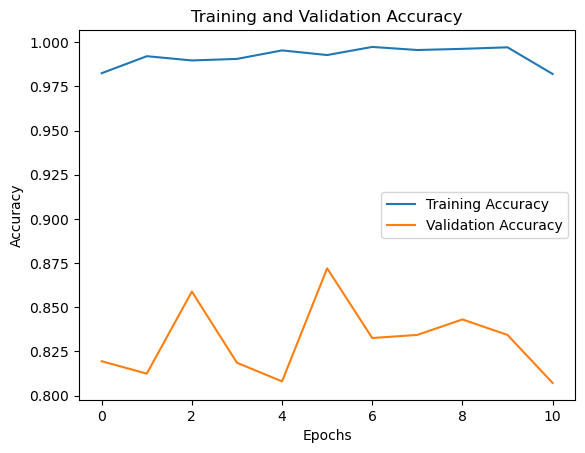

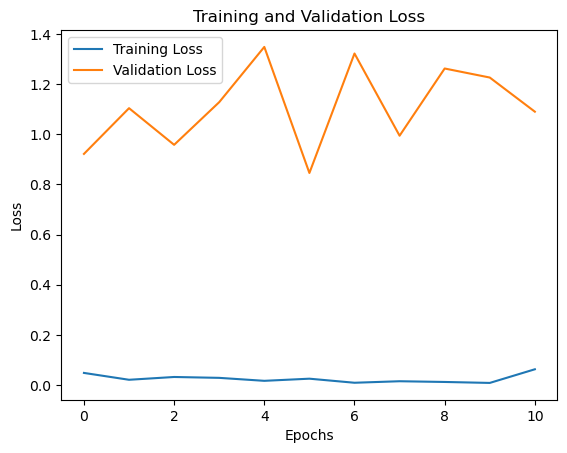

In [128]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [129]:
print("Final Training Accuracy: ", history.history['accuracy'][-1])
print("Final Validation Accuracy: ", history.history['val_accuracy'][-1])

Final Training Accuracy:  0.9820607900619507
Final Validation Accuracy:  0.8071866631507874


 1/41 [..............................] - ETA: 5s

2024-10-02 21:44:29.304644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


41/41 [==============================] - 3s 79ms/step


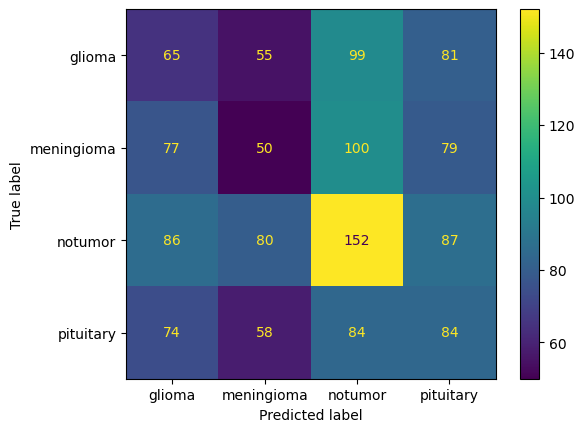

In [131]:
predictions = best_model.predict(test_data)
y_pred = np.argmax(predictions, axis=1)
y_true = test_data.classes
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()

In [132]:
cr = classification_report(y_true, y_pred)
print('Classification Report:\n', cr)

Classification Report:
               precision    recall  f1-score   support

           0       0.22      0.22      0.22       300
           1       0.21      0.16      0.18       306
           2       0.35      0.38      0.36       405
           3       0.25      0.28      0.27       300

    accuracy                           0.27      1311
   macro avg       0.26      0.26      0.26      1311
weighted avg       0.26      0.27      0.26      1311



### Using Transfer Learning (Pretrained model)